In [ ]:
#OBJECTIVE 1:
#FINDING THE CORREALATION BETWEEN TEMPERATURE AND GLOBAL WARMING GASES
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets

# hide warnings
import warnings
warnings.simplefilter("ignore")

# checking if plotly is installed; install otherwise

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# checking if seaborn is installed; install otherwise
try:
    import seaborn as sns
except:
    ! pip install --user seaborn
    import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/pollution_us_2000_2016.csv')
new_df = df.drop(['Unnamed: 0','State Code', 'County Code', 'Site Num', 'Address',
       'State', 'County', 'NO2 Units', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour', 'O3 Units',
       'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour','CO Units', 'CO Mean','CO 1st Max Value', 'CO 1st Max Hour'],axis = 1)

In [ ]:
no2_df = new_df.drop(['O3 AQI', 'SO2 AQI', 'CO AQI'],1)

# Every day has multiple values, so we will take only the maximum values of NO2 AQI every day
no2_df = no2_df.sort_values('NO2 AQI', ascending = 0).drop_duplicates(subset='Date Local', keep='first')

# Convert Date Local to datatime format
no2_df['Date Local'] = pd.to_datetime(no2_df['Date Local'])
no2_df.index = no2_df['Date Local']
del no2_df['Date Local']

# Consider only New York City
no2_df = no2_df[no2_df['City'] == 'New York']

# Calculate mean N02 AQI per year
no2_df = no2_df.resample("A").mean()
no2_df= no2_df.sort_index()
no2_df = no2_df.dropna()

#-----------------------------------------------------------------------------------------------------------------#

# For SO2
so2_df = new_df.drop(['O3 AQI', 'NO2 AQI', 'CO AQI'],1)
so2_df = so2_df.sort_values('SO2 AQI',ascending = 0).drop_duplicates(subset='Date Local', keep='first')
so2_df['Date Local'] = pd.to_datetime(so2_df['Date Local'])
so2_df.index = so2_df['Date Local']
del so2_df['Date Local']
so2_df = so2_df[so2_df['City'] == 'New York']
so2_df = so2_df.resample("A").mean()
so2_df= so2_df.sort_index()
so2_df = so2_df.dropna()
so2_df.head()

#-----------------------------------------------------------------------------------------------------------------#

# For CO
co_df = new_df.drop(['SO2 AQI', 'NO2 AQI', 'O3 AQI'],1)
co_df = co_df.sort_values('CO AQI',ascending = 0).drop_duplicates(subset='Date Local', keep='first')
co_df['Date Local'] = pd.to_datetime(co_df['Date Local'])
co_df.index = co_df['Date Local']
del co_df['Date Local']
co_df = co_df[co_df['City'] == 'New York']
co_df = co_df.resample("A").mean()
co_df= co_df.sort_index()
co_df = co_df.dropna()

In [ ]:
# Data Cleaning for Temperature Data where we are only considering the Temperature for New York City
df = pd.read_csv("/content/GlobalLandTemperaturesByCity.csv")
df = df[df['Country'] == 'United States']
df = df[df['City'] == 'New York']
df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)

# Convert the Date Local column to date time format
df['Date Local'] = pd.to_datetime(df['dt'])
# set first column (dt) as the index column
df.index = df['Date Local']
del df['dt'],df['City'],df['Country']
df.dropna()

# As we have only one value per day we dont need to drop duplicates so this will calculate the Annual Mean Temperature
df = df.resample("A").mean()

df = df.dropna()
df = df.sort_index()

In [ ]:
# Joining different Pollution Data with the Temperature Data

j1 = pd.merge(df, no2_df, left_index = True, right_index = True, how='inner')
j2 = pd.merge(so2_df, j1, left_index = True, right_index = True, how='inner')
j3 = pd.merge(co_df, j2, left_index = True, right_index = True, how='inner')
j3.head()

,CO AQI,SO2 AQI,AverageTemperature,NO2 AQI
Date Local,,,,
2000-12-31,30.250000,62.476190,9.969083,70.000000
2001-12-31,19.000000,61.285714,10.931000,75.735294
2002-12-31,17.625000,59.342105,11.252167,71.692308
2003-12-31,19.357143,59.388889,9.836000,66.148148
2004-12-31,15.538462,53.675676,10.389500,64.921053


In [ ]:
# Normalize the data so that all the column data can be compared
j3_norm = (j3 - j3.mean()) / (j3.max() - j3.min())
j3_norm.head()


,CO AQI,SO2 AQI,AverageTemperature,NO2 AQI
Date Local,,,,
2000-12-31,0.654585,0.357917,-0.404637,0.347543
2001-12-31,0.132401,0.329215,0.008577,0.575799
2002-12-31,0.068578,0.282354,0.146542,0.414894
2003-12-31,0.148978,0.283482,-0.461806,0.194245
2004-12-31,-0.028272,0.145735,-0.224037,0.145408


In [ ]:
trace0 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['AverageTemperature'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['CO AQI'],
    mode = 'lines',
    name = 'Carbon Monoxide'
)

trace3 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['SO2 AQI'],
    mode = 'lines',
    name = 'Sulphur Dioxide'
)

trace4 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['NO2 AQI'],
    mode = 'lines',
    name = 'Nitrogen Dioxide'
)

layout = go.Layout(
    title='Temperature and Pollution Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

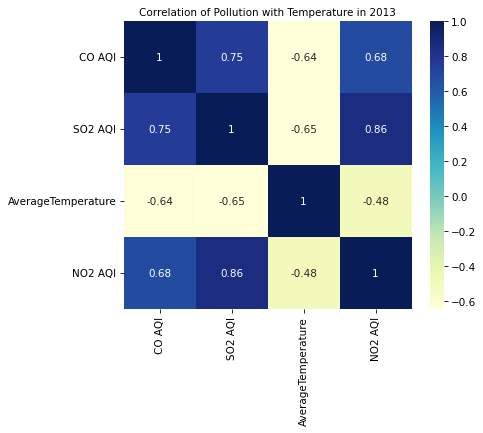

In [ ]:
fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8])
sns.heatmap(j3_norm.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Pollution with Temperature in 2013", fontsize=10)
plt.show()


In [ ]:
# section 2
df = pd.read_csv("/content/GlobalLandTemperaturesByCity.csv")

# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']

df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude","Country"}, 1)

df = df.dropna()

df = df[df['City']=='New York']
df = df.drop({'City'},1)
df = df.resample("A").mean()

In [ ]:
gg_df = pd.read_csv("/content/greenhouse_gas_inventory_data_data.csv")

df_usa = gg_df[gg_df['country_or_area']=='United States of America'].drop('country_or_area', 1)

# getting yearly emissions for the 4 major greenhouse gases i.e. CO2, Methane, Nitrous Oxide and HCFCs
df_usa_co2 = df_usa[df_usa['category']=='carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_co2 = df_usa_co2.sort_values('year')
df_usa_co2.columns=['year','co2']

df_usa_methane = df_usa[df_usa['category']=='methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_methane = df_usa_methane.sort_values('year')
df_usa_methane.columns=['year','methane']

df_usa_n2o = df_usa[df_usa['category']=='nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_n2o = df_usa_n2o.sort_values('year')
df_usa_n2o.columns=['year','n2o']

df_usa_hcfc = df_usa[df_usa['category']=='hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_hcfc = df_usa_hcfc.sort_values('year')
df_usa_hcfc.columns=['year','hcfc']

# Set Index
df_usa_co2.index = df_usa_co2['year']
df_usa_methane.index = df_usa_methane['year']
df_usa_n2o.index = df_usa_n2o['year']
df_usa_hcfc.index = df_usa_hcfc['year']

del df_usa_co2['year'],df_usa_methane['year'],df_usa_n2o['year'],df_usa_hcfc['year']

In [ ]:
co2 = df_usa_co2['co2']
n2o = df_usa_n2o['n2o']
methane = df_usa_methane['methane']
hcfc = df_usa_hcfc['hcfc']
temp = list(df['AverageTemperature'])[-25:]

part3 = pd.DataFrame({'co2':co2,'n2o':n2o,'methane':methane,'hcfc':hcfc,'temp': temp},columns = ['co2','n2o','methane','hcfc','temp'])
part3.head()


,co2,n2o,methane,hcfc,temp
year,,,,,
1990,5.115095e+06,406228.526626,773854.896420,46288.814184,9.661333
1991,5.064880e+06,396113.656867,777034.220915,41618.413588,11.322500
1992,5.170274e+06,404052.107073,776869.789752,47427.662176,11.357250
1993,5.284759e+06,420503.190940,764089.671267,47500.262267,9.572667
1994,5.377492e+06,402478.930460,770450.426146,53246.654974,10.040917


In [ ]:
part3_norm = (part3 - part3.mean()) / (part3.max() - part3.min())

In [ ]:
trace0 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['temp'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['co2'],
    mode = 'lines',
    name = 'Carbon Dioxide'
)

trace2 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['n2o'],
    mode = 'lines',
    name = 'Nitrous Oxide'
)

trace3 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['methane'],
    mode = 'lines',
    name = 'Methane'
)

trace4 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['hcfc'],
    mode = 'lines',
    name = 'Hydrofluorocarbon'
)


layout = go.Layout(
    title='Temperature and Greenhouse Gases Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace2,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

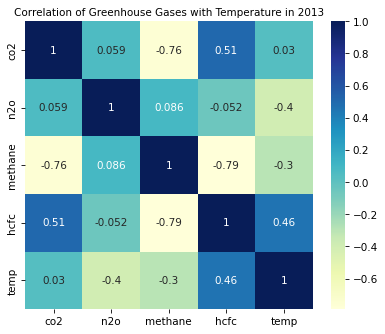

In [ ]:
fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8])
sns.heatmap(part3.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Greenhouse Gases with Temperature in 2013", fontsize=10)
plt.show()

In [ ]:
#OBJECTIVE 2:
#VISUALISATION OF GLOBAL CHANGES

In [ ]:
# Importing the libraries we will be needing
import pandas as pd  # Data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px  # Data visualizations

# Uploading the global temperature dataset to Colab if not already done

# Assuming you've uploaded the file using the Colab interface,
# the file should be in the current working directory ("/content/")
# Make sure the file name matches the actual file you uploaded.

# Reading the global temperature dataset
temp = pd.read_csv("/content/Global_annual_mean_temp.csv")

# Creating a line chart
fig = px.line(temp, x='Year', y='No_Smoothing',
              color_discrete_sequence=['red'],
              markers=True,
              title="Global Surface Temperatures",
              labels={"No_Smoothing": "Temperature Difference in Celsius"}
              )
fig.show()

In [ ]:
#downloading the ocean heat dataset
octemp = pd.read_csv('/content/ohc_levitus_climdash_seasonal (2).csv')

#creating a line chart
fig = px.line(octemp, x='Year', y='heat content anomaly (10^22  Joules)',
              color_discrete_sequence = ['purple'],
              markers=True,
              title='Ocean Heat Content')
fig.show()

In [ ]:
co2 = pd.read_csv("/content/co2_mm_mlo (1).csv")

#creating a line chart
fig = px.line(co2, x='decimal date', y='average',
              color_discrete_sequence = ['blue'],
              markers=True,
              hover_data=['year','month','average'],
              title='Mauna Loa Observatory CO2 Parts Per Million',
              labels={'decimal date':'year', 'average':'CO2 ppm'})
fig.show()


In [ ]:
#downloading the ch4 dataset
ch4 = pd.read_csv("/content/Global_monthly_mean_ch4.csv")

#creating a line chart
fig = px.line(ch4, x='decimal', y='average',
              color_discrete_sequence = ['yellow'],
              markers=True,
              title='Global Methane Parts Per Billion',
              labels={'decimal':'year','average':'CH4 ppb'})
fig.show()


In [ ]:
#downloading the arctic ice dataset
ice = pd.read_csv("/content/arctic_ice_extent.csv")

#creating a line chart
fig = px.line(ice, x='year', y='extent',
              color_discrete_sequence = ['light blue'],
              markers=True,
              title='Arctic Sea Ice',
              labels={'extent': 'million sq km'}
              )
fig.show()

In [ ]:
#downloading the antarctica mass dataset
antarctica = pd.read_csv("/content/Antartica_mass (1).csv")

#creating a line chart
fig = px.line(antarctica, x='year', y='Antarctic mass',
              color_discrete_sequence = ['black'],
              markers=True,
              title='Antarctica Mass',
              labels={'Antarctic mass':'Mass in Gt'}
             )
fig.show()


In [ ]:
#downloading the sea level dataset
sealevels = pd.read_csv('/content/Global_sea_level_rise.csv')

#creating a line chart
fig = px.line(sealevels, x='year', y='mmfrom1993-2008average',
              color_discrete_sequence = ['blue'],
              markers=True,
              title='Global Sea Levels',
              labels={'mmfrom1993-2008average':'mm from average'}
             )
fig.show()